In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

cpu


In [2]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    running_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        reconstruction, mean, logvar = model(data)
        recon_loss = criterion(reconstruction, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + alpha * kl_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)

            running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 文件夹路径
folder_path = '5min_smoothed_data/'

# 采样率 (每秒2次，即2Hz)
sampling_rate = 2  # 2Hz
max_duration = 5 * 60  # 最长5分钟，单位为秒
max_length = max_duration * sampling_rate  # 最大数据点数

# 初始化一个列表用于存储处理后的数据
bci_data_list = []

# 遍历文件夹中的每个 CSV 文件
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # 读取 EEG 数据
        file_path = os.path.join(folder_path, filename)
        eeg_data = pd.read_csv(file_path)
        
        # 提取 BCI 数据
        bci_series = eeg_data['BCI'].values
        
        # 获取当前数据的长度
        current_length = len(bci_series)
        
        # 中心化处理：如果信号长度大于 max_length，则截断；如果小于 max_length，则填充
        if current_length < max_length:
            # 填充：信号不足的部分用 -1 填充，居中对齐
            pad_size = max_length - current_length
            left_pad = pad_size // 2
            right_pad = pad_size - left_pad
            bci_series = np.pad(bci_series, (left_pad, right_pad), 'constant', constant_values=-1)
        elif current_length > max_length:
            # 截断：信号超长时，居中截断到 max_length
            start_index = (current_length - max_length) // 2
            bci_series = bci_series[start_index:start_index + max_length]

        # 将数据添加到列表中
        bci_data_list.append(bci_series)

# 转换为 numpy 数组，并转换为 PyTorch 张量
bci_data_array = np.array(bci_data_list)
bci_data_tensor = torch.tensor(bci_data_array, dtype=torch.float32).unsqueeze(1)  # 增加 channel 维度

# 划分训练集和测试集
train_data, test_data = train_test_split(bci_data_tensor, test_size=0.2, random_state=42)

# 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 输出数据形状，检查是否正确
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: torch.Size([432, 1, 600])
Test data shape: torch.Size([108, 1, 600])


In [4]:
# 定义模型的参数
latent_dim = 10  # 潜在空间维度
initial_channels = 128  # 初始的通道数量
seq_length = max_length  # 每个样本的长度，即 600 个数据点

# 创建 VAE 模型
vae_model = VAE(latent_dim)
vae_model = vae_model.to(device)
print(f'The model has {count_parameters(vae_model):,} parameters')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 定义学习率调度器
warmup_epochs = 8
min_lr = 5e-6
gamma = 0.99
scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1.0)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# 训练参数
epochs = 100  # 训练的 epoch 数
alpha = 1e-6  # KL 散度系数，用于 VAE 的损失函数
patience = 10  # 提前停止的耐心值
best_test_loss = float('inf')
epochs_no_improve = 0

# 保存训练和测试损失
train_loss_values = []
test_loss_values = []

# 训练和测试循环
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.8f}")
    
    # 更新学习率
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()
    
    # 保证学习率不低于 min_lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)
    
    # 检查早停条件
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break


The model has 363,365 parameters
Epoch 1, Train Loss: 0.9451, Test Loss: 0.9062, LR: 0.00012500
Epoch 2, Train Loss: 0.8977, Test Loss: 0.7763, LR: 0.00025000
Epoch 3, Train Loss: 0.6375, Test Loss: 0.5569, LR: 0.00037500
Epoch 4, Train Loss: 0.4704, Test Loss: 0.4378, LR: 0.00050000
Epoch 5, Train Loss: 0.4285, Test Loss: 0.3780, LR: 0.00062500
Epoch 6, Train Loss: 0.4046, Test Loss: 0.3648, LR: 0.00075000
Epoch 7, Train Loss: 0.3713, Test Loss: 0.3199, LR: 0.00087500
Epoch 8, Train Loss: 0.3370, Test Loss: 0.3042, LR: 0.00100000
Epoch 9, Train Loss: 0.3252, Test Loss: 0.2955, LR: 0.00100000
Epoch 10, Train Loss: 0.3139, Test Loss: 0.2843, LR: 0.00099000
Epoch 11, Train Loss: 0.3022, Test Loss: 0.2685, LR: 0.00098010
Epoch 12, Train Loss: 0.2832, Test Loss: 0.2466, LR: 0.00097030
Epoch 13, Train Loss: 0.2657, Test Loss: 0.2325, LR: 0.00096060
Epoch 14, Train Loss: 0.2524, Test Loss: 0.2195, LR: 0.00095099
Epoch 15, Train Loss: 0.2372, Test Loss: 0.1889, LR: 0.00094148
Epoch 16, Train 

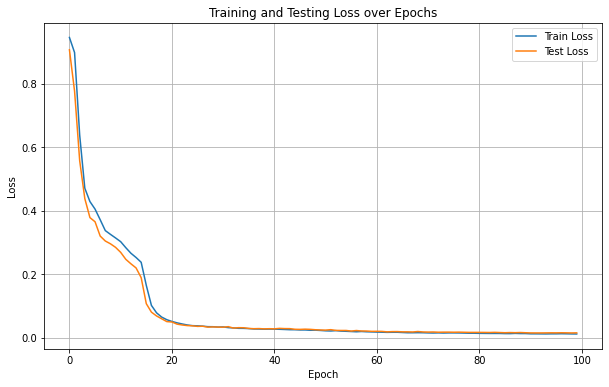

In [5]:
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Check the latent variable shape
train_latent_vars = get_latent_variables(vae_model, train_loader)
test_latent_vars = get_latent_variables(vae_model, test_loader)
print(train_latent_vars.shape[1])
print(test_latent_vars.shape[1])

10
10


In [7]:
# Save VAE model
torch.save(vae_model.state_dict(), 'vae_model_2.pth')
print("VAE model saved as vae_model_2.pth")

VAE model saved as vae_model_2.pth
